<a href="https://colab.research.google.com/github/tannyb28/afib/blob/main/Machine_Learning_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Import the modules we need
These are the common ones we've used previously

In [ ]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

## Mount your Google Drive to this Colab session
We are doing this so that we can read in data that is stored on your Google Drive (your ECG training data)

When you run the drive.mount() function, it will give you a link to click so that you authenticate your Google account.  Follow the prompts and it will give you a long password that you can copy and paste into the box that shows up below this block of code.  Once you do that, you will be able to access your Google Drive from this Colab session.

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


## Load in the ECG data from the file
Store the file in a list of lines in the file that we will process to get the ECG data.

*fname* is the location I stored my ECG data file.  You will have to change this to where you saved the ECG data on your Google Drive

In [ ]:
# Change fname to correct location
fname = '/content/gdrive/MyDrive/Colab Notebooks/physionet2017_ECG_training_data.csv'
with open( fname ) as file:
  lines = file.readlines()

## Parse each line of ECG data
The last piece of data on each line is the label, the second to last piece of data on each line is a 'name' identifier, which is some sort of unique ID that we don't care about.

The rest of the data on each line is the ECG signal collected at 300 Hz.  The original data was of variable length, but for this project, each line contains exactly 2000 data points from the ECG.

### All we did here was take each of the 2000 data points and made them each a feature for our model.
*You may want to consider some pre-processing or data manipulation to give the model a different set of features.*

In [ ]:
# Set up a list of features and list of corresponding labels
features = []
labels = []
for line in lines:

# We know its a .csv file, so split each line apart by commas
    pieces = line.split(',')

# The last piece of data on each line is the label (0,1,2,3)
# We have to convert it from string to float and then to an integer to get a (0,1,2,3)
    labels.append( int( float( pieces[-1].strip() ) ) )

# Split out the ECG data (don't include the last two columns)
# At this poitnt each piece is still treated as a string, so it has to be converted to a floating point number
    string_data=pieces[0:-2]

# Store all the data for each case in a list
    data = []
    for piece in string_data:
        data.append( float( piece ) )

# Store the ECG data as a tensor in the features list
    features.append( tf.convert_to_tensor( data ) )

## Resample data to make number of samples smaller

In [ ]:
# This will resample data --- the best it can do is dobule the number of samples or half the number of samples
# If the required resampling is outside that range, it would be better to call this multiple times
def resample_data( input_data, num_resample_points ):
    input_length = len( input_data )

# Save time if there is no change in the sampling
    if input_length == num_resample_points:
        return input_data

# When downsampling, calculate how many points to get rid of and evenly space them out
# Create a list of indices to cut out and use the conveneient numpy function delete
# to simultanseously remove all of the specificed indices
    elif input_length > num_resample_points:
        points_to_cut = input_length - num_resample_points - 1
        cut_every = np.floor( input_length / points_to_cut )
        cut_indices = []
        for i in range(1,points_to_cut+1):
            cut_indices.append( int(i*cut_every) )
        return np.delete( input_data, cut_indices )

# When upsampling, it takes more time because we have to go through every point
# in the data.  When adding a point, add a point that is the average of two
# adjacent points.
    else:
        points_to_add = num_resample_points - input_length
        add_every = np.floor( input_length / points_to_add )
        counter = 0
        output_data = []
        for i in range(0,input_length-1):
            output_data.append( input_data[i] )
            if counter < add_every:
                counter += 1
            else:
                counter = 0
                output_data.append( ( input_data[i]+input_data[i+1] ) / 2.0 )
        output_data.append( input_data[-1] )
        return output_data

In [ ]:
# Downsample from 1999 points to 500 points
new_features = []
for feature in features:
    new_features.append( tf.convert_to_tensor( resample_data( feature, 1000 ) ) )

# We are also going to force the data to 16 bit floating point type to save a little bit of memory/disk space
# We don't need 32 bits precision for this
new_features2 = []
for feature in new_features:
    new_features2.append( tf.cast( tf.convert_to_tensor( resample_data( feature, 500 ) ), tf.float16 ) )

# We are also going to force the data to 16 bit floating point type to save a little bit of memory/disk space
# We don't need 32 bits precision for this
# for feature in new_features:
    # new_features2.append( tf.cast( tf.convert_to_tensor( new_features ), tf.float16 ) )


In [ ]:
print(len(new_features[0]))

1001


## Look at the ECG data
Set EXAMPLE to some number which is the index of the ECG trace to look at
This snippet will plot the ECG trace and report the label

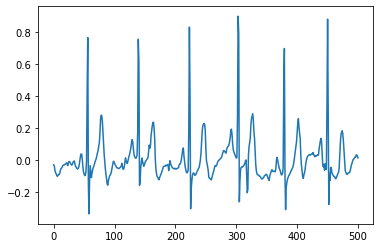

2


In [ ]:
EXAMPLE = 7527
plt.figure()
plt.plot( new_features2[EXAMPLE] )
plt.show()
print( labels[EXAMPLE] )

## Split the data up into a training set and a validation set
Had to use convert to tensor function to convert the input for the model from a list to a tensor.

In [ ]:
from sklearn.model_selection import train_test_split
train_features, val_features, train_labels, val_labels = train_test_split( new_features2, labels, test_size=0.2 )
train_features = tf.convert_to_tensor( train_features )
val_features = tf.convert_to_tensor( val_features )

## Convert the output categories from a single integer value into one-hot vectors
The result of the IntegerLookup layer will be each of the classifications (0,1,2,3) plus a -1 which indicates 'Unknown'

Encode both the training and testing labels as one-hot vectors

*You don't necessarily have to do this step if you don't want to use one-hot vectors for output.*

In [ ]:
# Set up one hot vector for output
categorizer = tf.keras.layers.IntegerLookup( output_mode = 'one_hot' )
categorizer.adapt( train_labels )
print( categorizer.get_vocabulary() )

# Now encode both the training and testing labels as one-hot vectors
encoded_labels = categorizer( train_labels )
encoded_val_labels = categorizer( val_labels )

[-1, 0, 2, 1, 3]


## Build and compile the model
* To do

In [ ]:
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Dense(units=150,activation='relu'))
model.add(tf.keras.layers.Dropout(0.7))
model.add(tf.keras.layers.Dense( 10,kernel_regularizer=tf.keras.regularizers.l1(0.01) ))
model.add(tf.keras.layers.Dense( 10,kernel_regularizer=tf.keras.regularizers.l2(0.01) ))
model.add( tf.keras.layers.Dense(units=5,activation='softmax'))

lr = 0.001
my_optimizer = tf.keras.optimizers.Adam(lr)
model.compile(optimizer=my_optimizer, loss=tf.keras.losses.CategoricalCrossentropy(), metrics=[tf.keras.metrics.CategoricalAccuracy()])


In [ ]:
print(len(new_features2[0]))

501


## Train the model
* To do

In [ ]:
num_epochs=30
batch_size=256
history = model.fit( train_features, encoded_labels, batch_size=batch_size, epochs=num_epochs, validation_data=(val_features,encoded_val_labels) )

Epoch 1/30
24/24 [==============================] - 1s 18ms/step - loss: 3.0253 - categorical_accuracy: 0.3987 - val_loss: 2.6021 - val_categorical_accuracy: 0.6102
Epoch 2/30
24/24 [==============================] - 0s 10ms/step - loss: 2.5271 - categorical_accuracy: 0.5809 - val_loss: 2.2962 - val_categorical_accuracy: 0.6109
Epoch 3/30
24/24 [==============================] - 0s 8ms/step - loss: 2.2415 - categorical_accuracy: 0.5915 - val_loss: 2.0603 - val_categorical_accuracy: 0.6109
Epoch 4/30
24/24 [==============================] - 0s 8ms/step - loss: 2.0076 - categorical_accuracy: 0.5925 - val_loss: 1.8568 - val_categorical_accuracy: 0.6109
Epoch 5/30
24/24 [==============================] - 0s 9ms/step - loss: 1.8039 - categorical_accuracy: 0.5953 - val_loss: 1.6836 - val_categorical_accuracy: 0.6096
Epoch 6/30
24/24 [==============================] - 0s 8ms/step - loss: 1.6396 - categorical_accuracy: 0.5945 - val_loss: 1.5356 - val_categorical_accuracy: 0.6109
Epoch 7/30
24/

## Plotting function
Same one we have been using before

In [ ]:
##########
# Plot the loss as a function of epoch.  Can use this plot to determine how the
# training went.
def plot_loss( epochs, loss, label, val=None ):

# Make a figure and add axes labels
    plt.figure()
    plt.xlabel( 'Epoch' )
    plt.ylabel( label )

# Just plot the loss vs the epoch number
    plt.plot( epochs, loss )
    if val != None:
      plt.plot( epochs, val )
    plt.show()
#
# End of plot_loss function
##########

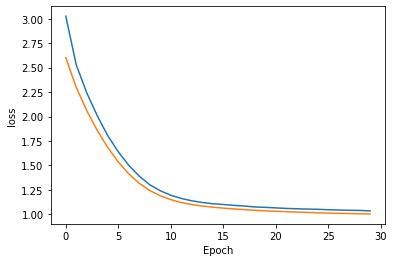

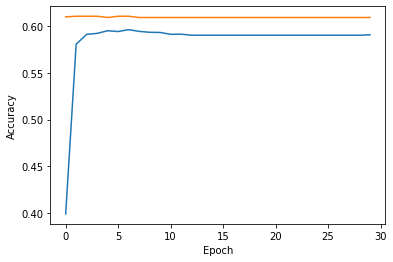

In [ ]:
plot_loss(history.epoch, history.history['loss'],'loss',history.history['val_loss'])
plot_loss(history.epoch, history.history['categorical_accuracy'],'Accuracy',history.history['val_categorical_accuracy'])

## Show the model
Use the plot_model() function to show a graphical representation of the model for the assignment

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 150)               75300     
                                                                 
 dropout (Dropout)           (None, 150)               0         
                                                                 
 dense_1 (Dense)             (None, 10)                1510      
                                                                 
 dense_2 (Dense)             (None, 10)                110       
                                                                 
 dense_3 (Dense)             (None, 5)                 55        
                                                                 
Total params: 76,975
Trainable params: 76,975
Non-trainable params: 0
_________________________________________________________________


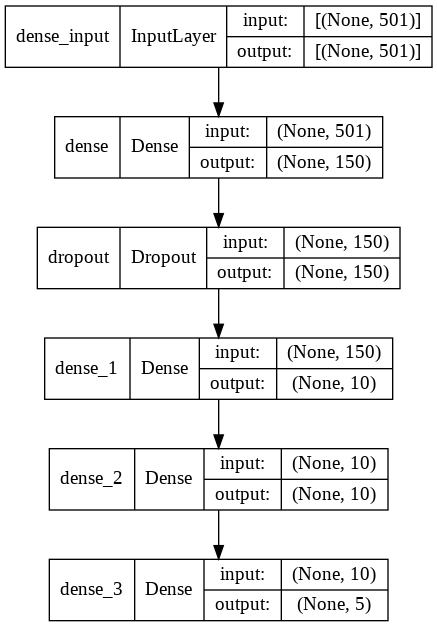

In [ ]:
model.summary()
tf.keras.utils.plot_model( model, show_shapes=True, expand_nested=True )

## Save the model
Use this command to save evetything about your model (the architecture, the trained weights) in HDF5 format -- you can save this anywhere, just make sure the extension is .h5 and it will save in the correct format.

This is useful because we don't want to have to rebuild the model and retrain the model every time we want to use it - especially if the model took a really long time to train.

In [ ]:
output_fname = '/content/gdrive/MyDrive/Colab Notebooks/my_ECG_model.h5'
model.save( output_fname )

## Use the saved model
Instructor will evaluate a set of test data by loading in your saved model


In [ ]:
model_fname = output_fname
saved_model = tf.keras.models.load_model( model_fname )

# Load in test data here
# test_features = []
# encoded_test_labels = []

encoded_test_labels = categorizer( test_labels )
results = saved_model.evaluate( np.asarray( test_features), np.asarray( encoded_test_labels) )

NameError: ignored